# Find the normal knee image with most slices and prepare data for VoxelMorph

## Find the normal knee image with most slices in a folder

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Load csv file
normalImageIndices = []
allImageIndices = []
with open('./MRNet-v1.0/train-abnormal.csv') as file:
    fileReader = csv.reader(file)
    # Find all the rows with abnormal as 0 and store their indices
    for row in fileReader:
        allImageIndices.append(row[0])
        if (row[1] == '0'):
            normalImageIndices.append(row[0])

In [3]:
print(normalImageIndices)
print(allImageIndices)

['0011', '0012', '0014', '0017', '0021', '0023', '0025', '0026', '0040', '0044', '0048', '0053', '0060', '0066', '0074', '0077', '0082', '0096', '0099', '0106', '0110', '0117', '0118', '0120', '0122', '0123', '0127', '0128', '0131', '0143', '0144', '0149', '0153', '0170', '0177', '0181', '0210', '0214', '0222', '0225', '0227', '0228', '0230', '0238', '0239', '0243', '0244', '0245', '0252', '0256', '0258', '0267', '0268', '0272', '0283', '0291', '0296', '0299', '0306', '0337', '0342', '0362', '0363', '0372', '0377', '0381', '0384', '0387', '0400', '0404', '0406', '0409', '0410', '0415', '0420', '0425', '0428', '0430', '0434', '0435', '0437', '0439', '0442', '0450', '0459', '0460', '0461', '0462', '0465', '0466', '0467', '0472', '0473', '0475', '0476', '0477', '0491', '0492', '0495', '0499', '0503', '0504', '0509', '0515', '0525', '0532', '0533', '0542', '0548', '0549', '0558', '0563', '0565', '0571', '0580', '0583', '0588', '0589', '0597', '0599', '0600', '0608', '0621', '0625', '0634',

In [4]:
# Check whether all images have same 2D shape
# with open('./MRNet-v1.0/train-abnormal.csv') as file:
#     fileReader = csv.reader(file)
#     x = None
#     y = None
#     for row in fileReader:
#         index = row[0]
#         temp = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
#         if (x == None and y == None):
#             x = temp.shape[1]
#             y = temp.shape[2]
#         elif (x != temp.shape[1] or y != temp.shape[2]):
#             print('There are images which have different 2D shape')

In [4]:
# Check which image has most slices
maxSlice = 0
resultIndex = None
for index in normalImageIndices:
    temp = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
    if (temp.shape[0] > maxSlice):
        resultIndex = index
        maxSlice = temp.shape[0]
        
print(maxSlice)
print(resultIndex)

52
0934


## Do rigid image transformation using simpleITK

In [25]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import clear_output

In [10]:
example_np = np.load('./MRNet-v1.0/train/axial/0000.npy')
example_itk = sitk.GetImageFromArray(example_np)
print(example_np.shape)
print(example_itk.GetSize())

(44, 256, 256)
(256, 256, 44)


In [11]:
atlas_np = np.load('./MRNet-v1.0/train/axial/0934.npy')
atlas_itk = sitk.GetImageFromArray(atlas_np)
print(atlas_np.shape)
print(atlas_itk.GetSize())

(52, 256, 256)
(256, 256, 52)


In [23]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []
    
# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()

In [15]:
initial_transform = sitk.CenteredTransformInitializer(atlas_itk, 
                                                      example_itk, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(example_itk, atlas_itk, initial_transform, sitk.sitkLinear, 0.0, example_itk.GetPixelID())

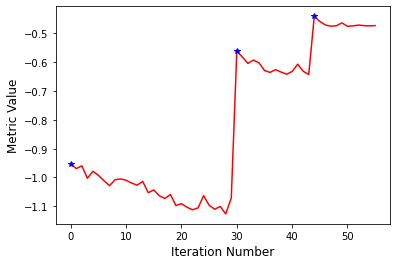

In [26]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(atlas_itk, sitk.sitkFloat32), 
                                               sitk.Cast(example_itk, sitk.sitkFloat32))

In [33]:
moving_resampled = sitk.Resample(example_itk, atlas_itk, final_transform, sitk.sitkLinear, 0.0, example_itk.GetPixelID())
# sitk.WriteImage(moving_resampled, os.path.join('.', 'RIRE_training_001_mr_T1_resampled.mha'))
moving_resampled_np = sitk.GetArrayViewFromImage(moving_resampled)

(52, 256, 256)


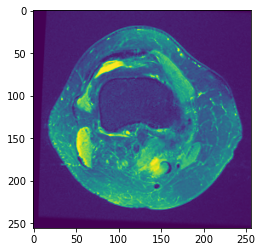

In [37]:
print(moving_resampled_np.shape)
plt.imshow(moving_resampled_np[9,:,:])

## Check if moving images' directions are the same as that of atlas and do flipping when necessary

### Load atlas image and sample moving image

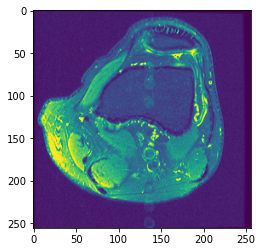

In [38]:
atlas = np.load('./MRNet-v1.0/train/axial/0934.npy')
plt.imshow(atlas[9,:,:])

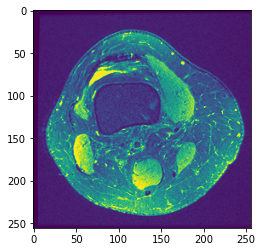

In [9]:
example = np.load('./MRNet-v1.0/train/axial/0000.npy')
plt.imshow(example[9,:,:])

### Check what is a reasonable pixel value for boundary

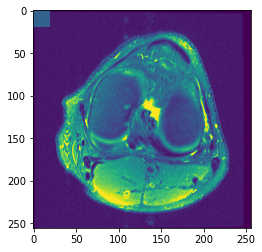

In [66]:
atlasMidSlice = atlas[26,:,:]
copy = np.copy(atlasMidSlice)
for i in range(20):
    for j in range(20):
        copy[i][j] = 80
plt.imshow(copy)
boundaryValue = 80

### Get the left, right boundaries and the top point

In [79]:
def getBounds(img):
    leftBound = 0
    rightBound = 255
    
    # Left bound
    shouldBreakOuterLoop = False
    for col in range(img.shape[1]):
        for row in range(img.shape[0]):
            if (img[row][col] >= boundaryValue):
                leftBound = col
                shouldBreakOuterLoop = True
                break
        if (shouldBreakOuterLoop):
            break
    # Right bound
    shouldBreakOuterLoop = False
    col = img.shape[1] - 1
    while (col > 0):
        for row in range(img.shape[0]):
            if (img[row][col] >= boundaryValue):
                rightBound = col
                shouldBreakOuterLoop = True
                break
        if (shouldBreakOuterLoop):
            break
        col -= 1

    return (leftBound, rightBound)

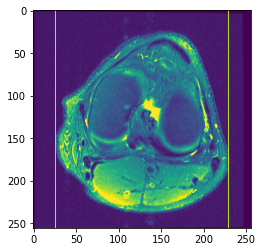

In [80]:
leftB, rightB = getBounds(atlasMidSlice)
copy1 = np.copy(atlasMidSlice)
for i in range(copy1.shape[0]):
    copy1[i][leftB] = 255
    copy1[i][rightB] = 255
plt.imshow(copy1)

In [86]:
def getTopPt(img):
    topPtX = 0
    topPtY = 0
    
    shouldBreakOuterLoop = False
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if (img[row][col] >= boundaryValue):
                topPtX = row
                topPtY = col
                shouldBreakOuterLoop = True
                break
        if (shouldBreakOuterLoop):
            break
    return (topPtX, topPtY)

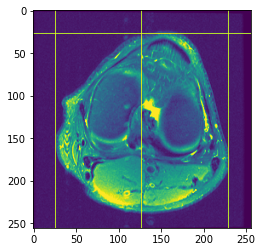

In [91]:
topPtX, topPtY = getTopPt(atlasMidSlice)
# Draw the vertical mid line
for i in range(copy1.shape[0]):
    copy1[i][math.floor((rightB + leftB) / 2)] = 255

# Draw the top boundary
for j in range(copy1.shape[1]):
    copy1[topPtX][j] = 255
plt.imshow(copy1)

### Define function for checking the direction of the img

In [96]:
def checkDirection(img):
    leftBound = 0
    rightBound = 255
    topPtX = 0
    topPtY = 0
    
    leftBound, rightBound = getBounds(img)
    topPtX, topPtY = getTopPt(img)
    
    mid = math.floor((leftBound + rightBound) / 2)
    if (topPtY > mid):
        return 'right'
    else:
        return 'left'

### Try on atlas and example moving images

In [97]:
print(checkDirection(atlasMidSlice))
exampleMidSlice = example[22,:,:]
print(checkDirection(exampleMidSlice))

right
left


(44, 256, 256)
right


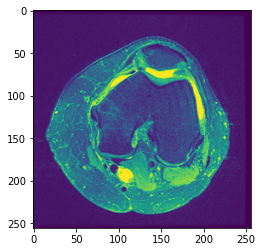

In [112]:
exampleFlipped = np.flip(example, 2)
print(exampleFlipped.shape)
print(checkDirection(exampleFlipped[22,:,:]))
plt.imshow(exampleFlipped[22,:,:])

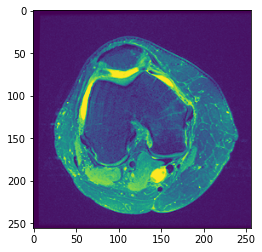

In [125]:
plt.imshow(example[22,:,:])

### Preprocess the data

In [126]:
targetSlice = 64
savePath = './MRNet-forVoxelMorph/processedData/{}'
for index in allImageIndices:
    curImg = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
    midSliceIdx = math.floor(curImg.shape[0] / 2)
    if (checkDirection(curImg[midSliceIdx, :, :]) == 'left'):
        curImg = np.flip(curImg, 2)
    
    if (curImg.shape[0] >= targetSlice):
        continue
    else:
        numSliceToPaddle = targetSlice - curImg.shape[0]
        curImg = np.pad(curImg, ((0, numSliceToPaddle), (0, 0), (0, 0)))
        np.savez(savePath.format(index), vol_data = curImg)    

15 253 16 108
2 240 16 120


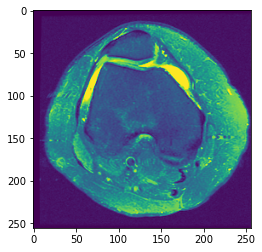

In [123]:
# There is problem in checking direction after flipping. But I believe filppng is doing its job.
img = np.load('./MRNet-v1.0/train/axial/0062.npy')
midSliceIdx = math.floor(img.shape[0] / 2)
plt.imshow(img[midSliceIdx, :, :])
l, r = getBounds(img[midSliceIdx, :, :])
x, y = getTopPt(img[midSliceIdx, :, :])
print(l, r, x, y)
img_f = np.flip(img, 2)
l, r = getBounds(img_f[midSliceIdx, :, :])
x, y = getTopPt(img_f[midSliceIdx, :, :])
print(l, r, x, y)

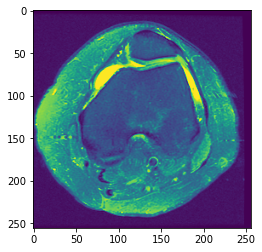

In [124]:
plt.imshow(img_f[midSliceIdx, :, :])

### Old approach to generate data (without flipping)

In [7]:
# Paddle zeros for all images with fewer slices (discard images with more slices)
targetSlice = 64
savePath = './MRNet-forVoxelMorph/processedData/{}'
with open('./MRNet-v1.0/train-abnormal.csv') as file:
    fileReader = csv.reader(file)
    for row in fileReader:
        index = row[0]
        temp = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
        if (temp.shape[0] > targetSlice):
            continue
        else:
            numSliceToPaddle = targetSlice - temp.shape[0]
            temp = np.pad(temp, ((0, numSliceToPaddle), (0, 0), (0, 0)))
            np.savez(savePath.format(index), vol_data = temp)

In [8]:
# Check if everything is right
for filename in os.listdir('./MRNet-forVoxelMorph/processedData'):
    temp = np.load(savePath.format(filename))['vol_data']
    if (temp.shape != (64, 256, 256)):
        print('error')

In [10]:
# Convert the atlas npy file into npz file
atlas = np.load('./MRNet-v1.0/train/axial/0934.npy')
atlas = np.pad(atlas, ((0, 12), (0, 0), (0, 0)))
print(atlas.shape)
np.savez('./MRNet-forVoxelMorph/atlas', vol = atlas)

(64, 256, 256)
